# Machine Learning Project - IA mention CentraleSupélec

Under the supervision of :

- Myriam TAMI

Students:

- Lucas Tramonte
- Rebecca Bayssari 
- Gabriel Souza 
- Kiyoshi Araki

# Libraries


In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler # it is not affected by outliers.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

from sklearn.feature_selection import f_regression, SelectKBest, RFECV


# EDA

In [51]:
data_original = pd.read_csv('Assets/Data/welddb.csv', delimiter='\s+', header=None)

In [52]:
data = data_original.copy()

# Name the columns
data.columns = [
    'Carbon concentration (weight%)', 
    'Silicon concentration (weight%)', 
    'Manganese concentration (weight%)', 
    'Sulphur concentration (weight%)', 
    'Phosphorus concentration (weight%)', 
    'Nickel concentration (weight%)', 
    'Chromium concentration (weight%)', 
    'Molybdenum concentration (weight%)', 
    'Vanadium concentration (weight%)', 
    'Copper concentration (weight%)', 
    'Cobalt concentration (weight%)', 
    'Tungsten concentration (weight%)', 
    'Oxygen concentration (ppm by weight)', 
    'Titanium concentration (ppm by weight)', 
    'Nitrogen concentration (ppm by weight)', 
    'Aluminium concentration (ppm by weight)', 
    'Boron concentration (ppm by weight)', 
    'Niobium concentration (ppm by weight)', 
    'Tin concentration (ppm by weight)', 
    'Arsenic concentration (ppm by weight)', 
    'Antimony concentration (ppm by weight)', 
    'Current (A)', 
    'Voltage (V)', 
    'AC or DC', 
    'Electrode positive or negative', 
    'Heat input (kJ/mm)', 
    'Interpass temperature (°C)', 
    'Type of weld', 
    'Post weld heat treatment temperature (°C)', 
    'Post weld heat treatment time (hours)', 
    'Yield strength (MPa)', 
    'Ultimate tensile strength (MPa)', 
    'Elongation (%)', 
    'Reduction of Area (%)', 
    'Charpy temperature (°C)', 
    'Charpy impact toughness (J)', 
    'Hardness (kg/mm2)', 
    '50% FATT', 
    'Primary ferrite in microstructure (%)', 
    'Ferrite with second phase (%)', 
    'Acicular ferrite (%)', 
    'Martensite (%)', 
    'Ferrite with carbide aggregate (%)', 
    'Weld ID'
]

# Replace 'N' with NaN
data.replace('N', pd.NA, inplace=True)

# Analysis of Yield Strenght

### Modeling - Regression

Including categoric features

In [53]:
def data_preprocessing_categorical(data, target_column, categoric_features=None, features_to_drop=None, drop_columns=None, y_imputation='zero',feature_selection_methods=None, pca=False, pca_n_components=None):
    """
    Function to perform data preprocessing including categorical features, imputing missing values and splitting the data into train and test.
    
    Parameters:
    - data: DataFrame containing the data.
    - target_column: Name of the target column.
    - categoric_features: List of categoric features.
    - drop_columns: List of specific columns to remove after converting to numeric.
    - features_to_drop : List of features to drop 
    - y_imputation: Strategy to impute missing values in the target column. Options are 'mean', 'median', 'mode'.
    - feature_selection_methods: List of dictionaries specifying feature selection methods to apply. 
        Each dictionary should contain {'method': 'method_name', 'params': {...}}.
        Supported methods: 'SelectKBest', 'RFECV'.
    - pca: Boolean indicating whether to apply PCA.
    - pca_n_components: Number of principal components to keep (if `pca=True`).
        
    Returns:
    - X_train, X_test, y_train, y_test: Processed training and testing DataFrames.
    """
    
    # Remove some features
    if drop_columns:
        data = data.drop(columns=drop_columns)
    
    # Convert columns to numeric 
    numeric_features = [col for col in data.columns if col not in ['Weld ID'] + categoric_features]
        
    data_categoric = data[categoric_features]
    data_numeric = data[numeric_features].apply(pd.to_numeric, errors='coerce')

    # Concatenate dataframes and Remove duplicates
    data = pd.concat([data_numeric, data_categoric], axis=1).drop_duplicates(keep='last')

    # Split data into features (X) and target (y)
    X = data.copy()
    y = data[target_column]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    percent_n = X_train.isnull().mean()
    cols_to_keep = percent_n[percent_n < 0.75].index

    X_train = X_train[cols_to_keep]
    
    # Convert categorical features to string
    X_train[categoric_features] = X_train[categoric_features].astype(str)
    X_test[categoric_features] = X_test[categoric_features].astype(str)
        
    # Impute missing values for the target variable (y)
    if y_imputation == 'mean':
        y_train = y_train.fillna(y_train.mean())
        # y_test = y_test.fillna(y_train.mean())
    elif y_imputation == 'median':
        y_train = y_train.fillna(y_train.median())
        # y_test = y_test.fillna(y_train.median())
    elif y_imputation == 'ffill':
        y_train = y_train.fillna(method='ffill')
        # y_test = y_test.fillna(method='ffill')
    elif y_imputation == 'zero':
        y_train = y_train.fillna(0)
        # y_test = y_test.fillna(0)
    
    # Impute missing values for Phosphorus and Sulphur with column mean
    for col in ['Phosphorus concentration (weight%)', 'Sulphur concentration (weight%)']:
        if col in X_train.columns:
            mean_value = X_train[col].mean()
            X_train[col] = X_train[col].fillna(mean_value)
            X_test[col] = X_test[col].fillna(mean_value)
    
    # For all other columns, replace missing values with 0
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    X_test = X_test[~y_test.isna()]
    y_test = y_test.dropna().astype(float)
    
    # For categorical variables, apply OneHotEncoding
    if categoric_features:
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categoric_features),
                ('num', StandardScaler(), [col for col in X_train.columns if col not in categoric_features])
            ]
        )
    else:
        preprocessor = ColumnTransformer(
            transformers=[('num', StandardScaler(), X_train.columns)]
        )
    
    # Apply feature selection methods if provided
    if feature_selection_methods:
        for method_info in feature_selection_methods:
            method = method_info['method']
            params = method_info.get('params', {})
            
            if method == 'SelectKBest':
                k = params.get('k', 10)  # Default to top 10 features if not specified
                select_kbest = SelectKBest(f_regression, k=k).fit(X_train, y_train)
                X_train = select_kbest.transform(X_train)
                X_test = select_kbest.transform(X_test)
            
            elif method == 'RFECV':
                estimator = params.get('estimator', RandomForestRegressor())
                step = params.get('step', 1)
                cv = params.get('cv', 5)
                scoring = params.get('scoring', 'r2')
                
                rfecv = RFECV(estimator=estimator, step=step, cv=cv, scoring=scoring)
                rfecv = rfecv.fit(X_train, y_train)
                
                X_train = rfecv.transform(X_train)
                X_test = rfecv.transform(X_test)
                
    # Apply PCA if specified
    if pca:
        pca_n_components = pca_n_components or min(X_train.shape[1], X_train.shape[0])  # Default to the smaller of the two dimensions
        pca_model = PCA(n_components=pca_n_components)
        
        X_train = pca_model.fit_transform(X_train)
        X_test = pca_model.transform(X_test)
        
        cumsum = np.cumsum(pca_model.explained_variance_ratio_)*100
        d = [n for n in range(len(cumsum))]
        plt.figure(figsize=(6, 6))
        plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
        plt.title('Cumulative Explained Variance as a Function of the Number of Components')
        plt.ylabel('Cumulative Explained variance')
        plt.xlabel('Principal components')
        plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
        plt.legend(loc='best')
    
    return X_train, X_test, y_train, y_test, preprocessor


def metrics_pipelines_categorical(X_train, X_test, y_train, y_test, preprocessor):
    """
    Function to fit models and evaluate performance metrics.
    """
    models = {
        "Linear Regression": Pipeline([("scaler", preprocessor), ("Regressor", LinearRegression())]),
        "Ridge Regression": Pipeline([("scaler", preprocessor), ("Regressor", Ridge())]),
        "Lasso Regression": Pipeline([("scaler", preprocessor), ("Regressor", Lasso())]),
        "ElasticNet Regression": Pipeline([("scaler", preprocessor), ("Regressor", ElasticNet())]),
        "Decision Tree Regression": Pipeline([("scaler", preprocessor), ("Regressor", DecisionTreeRegressor(random_state=42))]),
        "Random Forest Regression": Pipeline([("scaler", preprocessor), ("Regressor", RandomForestRegressor(random_state=42))]),
        "Gradient Boosting Regression": Pipeline([("scaler", preprocessor), ("Regressor", GradientBoostingRegressor(random_state=42))])
    }

    # Initialize an empty list to store the results
    results = []
    models_predictions = {}
    pipelines = {}

    # Loop over each model, fit the pipeline, and calculate metrics
    for model_name, pipeline in models.items():
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Predict the target on the test set
        y_pred = pipeline.predict(X_test)
        
        # store pipelines and predictions
        pipelines[model_name] = pipeline
        models_predictions[model_name] = y_pred
        
        # Calculate evaluation metrics
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        # Append the results to the list as a dictionary
        results.append({
            "Model": model_name,
            "MAPE": mape,
            "R2 Score": r2,
            "MSE": mse
        })
    
    # Convert the results into a Pandas DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Sort the DataFrame by R2 Score (or any other metric)
    results_df = results_df.sort_values(by="R2 Score", ascending=False).reset_index(drop=True)
    
    return results_df, models_predictions, pipelines

In [54]:
categoric_features = ['AC or DC', 'Electrode positive or negative', 'Type of weld']
features_to_drop = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]
drop_columns=["Charpy temperature (°C)", "50% FATT"]


X_train, X_test, y_train, y_test, preprocessor = data_preprocessing_categorical(data, target_column="Yield strength (MPa)", categoric_features=categoric_features, features_to_drop=features_to_drop, drop_columns=drop_columns, y_imputation='median')

results_df, models_predictions, pipelines = metrics_pipelines_categorical(X_train, X_test, y_train, y_test, preprocessor)
results_df

,Model,MAPE,R2 Score,MSE
0,Random Forest Regression,0.002724,0.998953,9.945714
1,Gradient Boosting Regression,0.005228,0.997950,19.472055
2,Decision Tree Regression,0.004192,0.997043,28.088243
3,Ridge Regression,0.073235,0.715998,2697.873490
4,Linear Regression,0.073171,0.715037,2706.999676
5,Lasso Regression,0.080910,0.676650,3071.657801
6,ElasticNet Regression,0.111536,0.395498,5742.463286


Analyzing overestimation

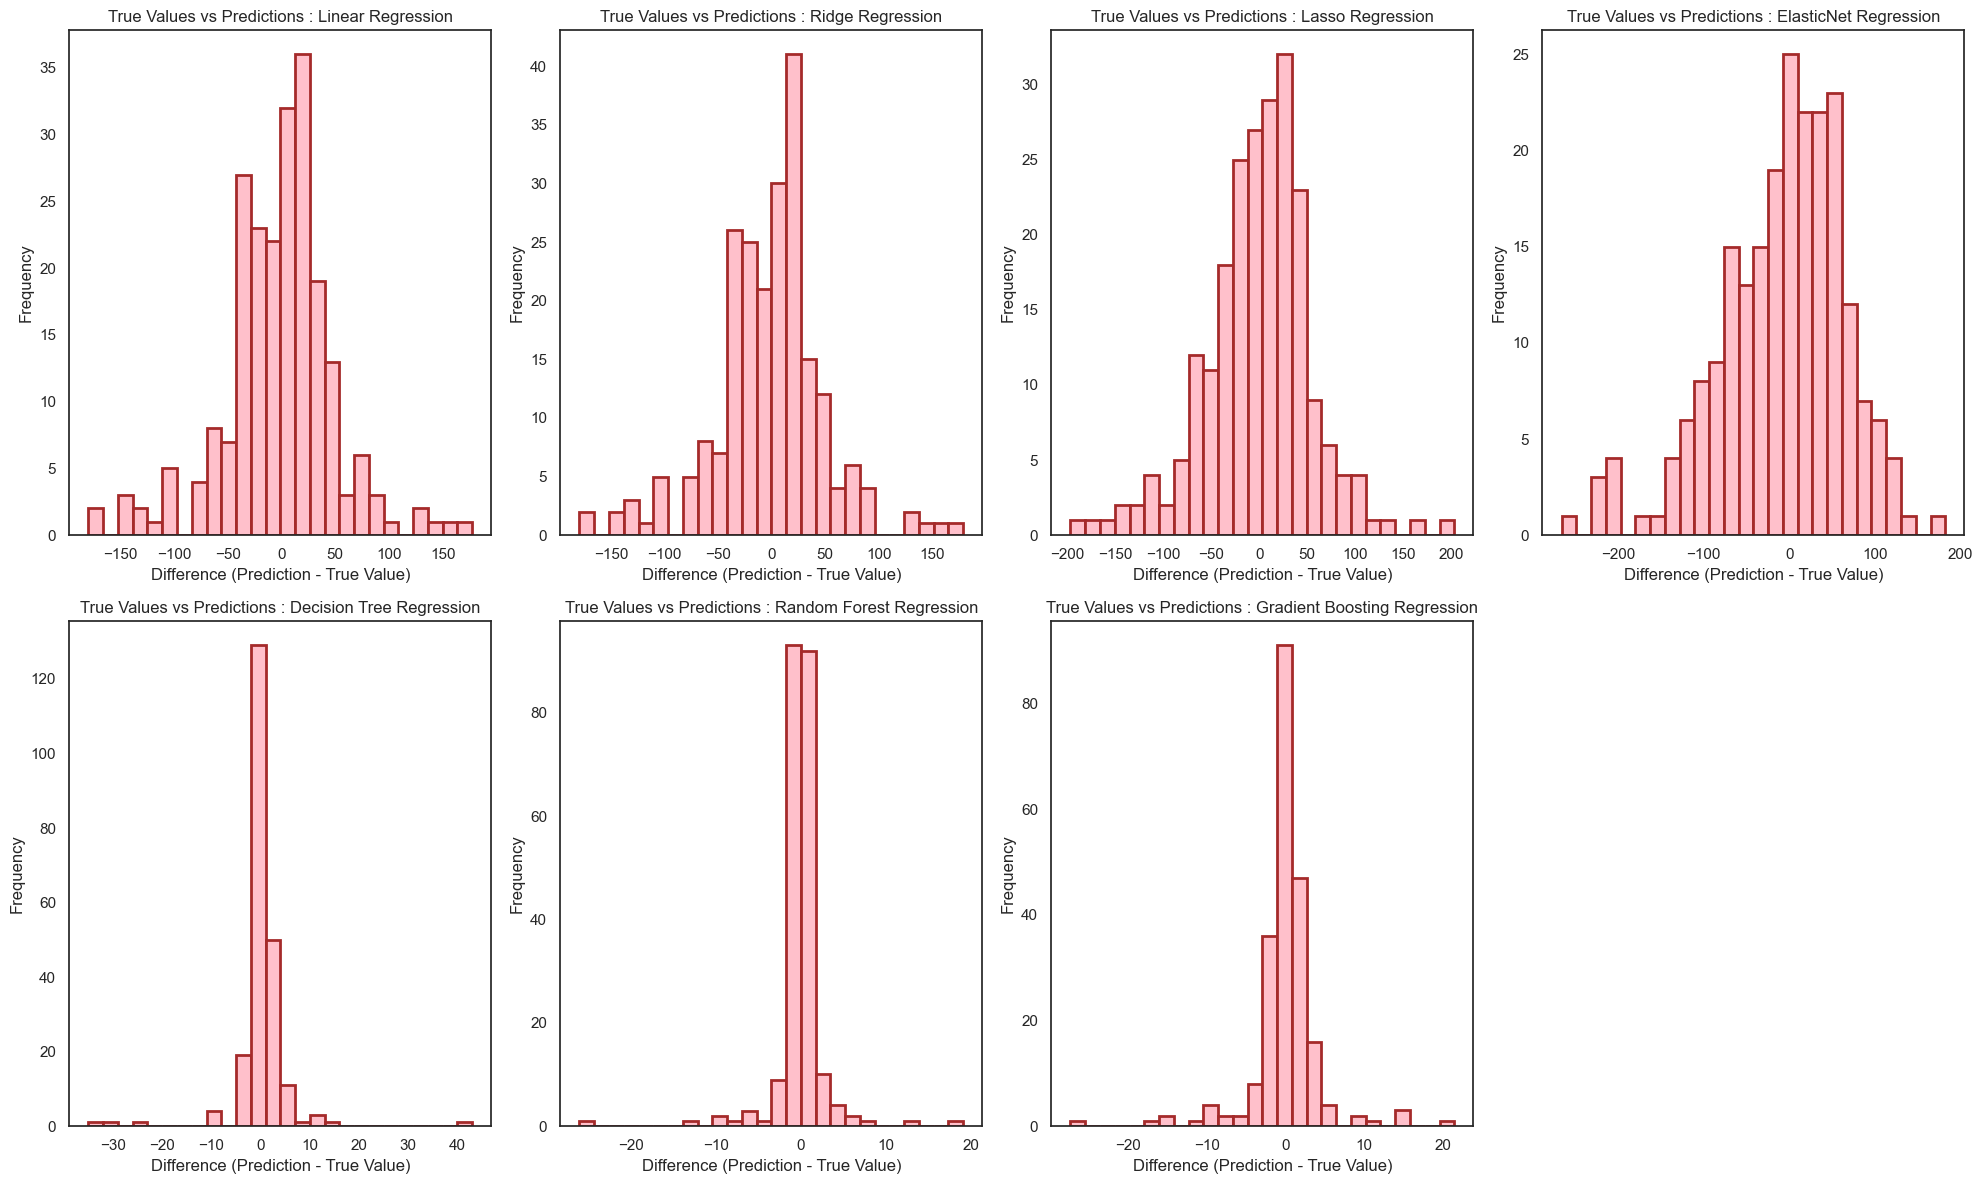

In [56]:
fig, axes = plt.subplots(2, 4, figsize=(20, 12)) 
axes = axes.flatten()  
fig.delaxes(axes[-1])

for i, (model_name, y_pred) in enumerate(models_predictions.items()):
    df_model = pd.DataFrame({'true': y_test, 'predicted': y_pred})
    df_model['diff'] = df_model['predicted'] - df_model['true']

    sns.set(style="white")
    axes[i].hist(df_model['diff'], bins=26, color="pink", edgecolor='brown', linewidth=2)
    axes[i].set_title(f'True Values vs Predictions : {model_name}', fontsize=12)
    axes[i].set_xlabel('Difference (Prediction - True Value)', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

Plotting learning curves to possibly identify overfitting

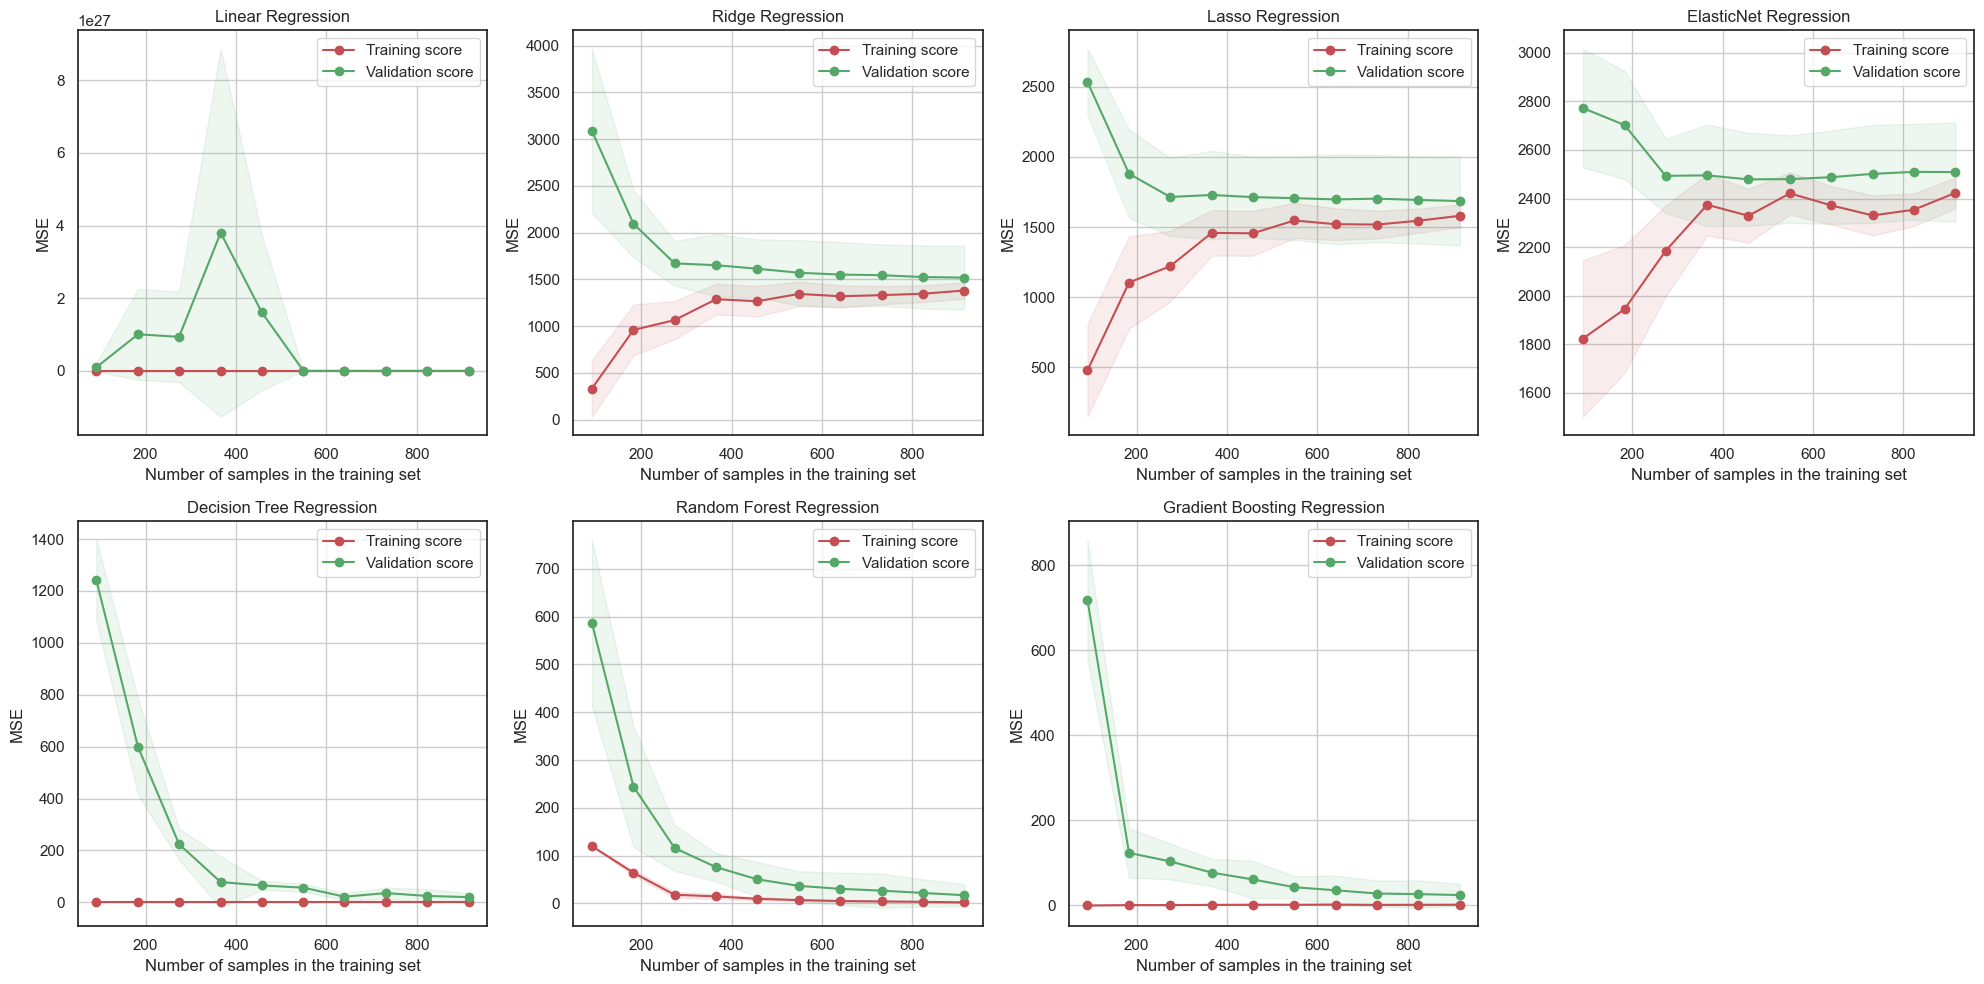

In [57]:
def plot_learning_curve_subplot(ax, model, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate mean and standard deviation
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    # Plot the learning curve
    ax.set_title(title)
    ax.set_xlabel("Number of samples in the training set")
    ax.set_ylabel("MSE")
    ax.grid()

    # Shaded area to represent standard deviation
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Training and validation score curves
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")

    ax.legend(loc="best")

# Create figure with subplots (4 in the first row and 3 in the second)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# List of model names for easy iteration
model_names = list(pipelines.keys())

# Loop through the models and plot learning curves
for i, model_name in enumerate(model_names):
    # Pass the model pipeline and title to the plot function
    plot_learning_curve_subplot(axes[i // 4, i % 4], 
                                pipelines[model_name], 
                                model_name, 
                                X_train, 
                                y_train)

# Remove the last subplot (as there are only 7 models)
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()

excluding categorical features

In [58]:
def data_preprocessing(data, target_column, categoric_features=None, features_to_drop=None, drop_columns=None, y_imputation='zero',feature_selection_methods=None, pca=False, pca_n_components=None):
    """
    Function to perform data preprocessing, imputing missing values and splitting the data into train and test.
    
    Parameters:
    - data: DataFrame containing the data.
    - target_column: Name of the target column.
    - categoric_features: List of categoric features.
    - drop_columns: List of specific columns to remove after converting to numeric.
    - features_to_drop : List of features to drop 
    - y_imputation: Strategy to impute missing values in the target column. Options are 'mean', 'median', 'mode'.
    - feature_selection_methods: List of dictionaries specifying feature selection methods to apply. 
        Each dictionary should contain {'method': 'method_name', 'params': {...}}.
        Supported methods: 'SelectKBest', 'RFECV'.
    - pca: Boolean indicating whether to apply PCA.
    - pca_n_components: Number of principal components to keep (if `pca=True`).
        
    Returns:
    - X_train, X_test, y_train, y_test: Processed training and testing DataFrames.
    """
    
    # Convert columns to numeric
    
    if features_to_drop:         
        numeric_features = data.drop(columns = categoric_features).columns
        data = data[numeric_features].apply(pd.to_numeric, errors='coerce')

    # Remove duplicates
    data = data.drop_duplicates(keep='last')
    
    # Remove some features
    data = data.drop(columns=drop_columns)

    # Split data into features (X) and target (y)
    X = data.drop(columns=features_to_drop)
    y = data[target_column]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Impute missing values for the target variable (y)
    if y_imputation == 'mean':
        y_train = y_train.fillna(y_train.mean())
        y_test = y_test.fillna(y_train.mean())
    elif y_imputation == 'median':
        y_train = y_train.fillna(y_train.median())
        y_test = y_test.fillna(y_train.median())
    elif y_imputation == 'ffill':
        y_train = y_train.fillna(method='ffill')
        y_test = y_test.fillna(method='ffill')
    elif y_imputation == 'zero':
        y_train = y_train.fillna(0)
        y_test = y_test.fillna(0)
    
    # Impute missing values for Phosphorus and Sulphur with column mean
    for col in ['Phosphorus concentration (weight%)', 'Sulphur concentration (weight%)']:
        if col in X_train.columns:
            mean_value = X_train[col].mean()
            X_train[col] = X_train[col].fillna(mean_value)
            X_test[col] = X_test[col].fillna(mean_value)
    
    # For all other columns, replace missing values with 0
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    # Apply feature selection methods if provided
    if feature_selection_methods:
        for method_info in feature_selection_methods:
            method = method_info['method']
            params = method_info.get('params', {})
            
            if method == 'SelectKBest':
                k = params.get('k', 10)  # Default to top 10 features if not specified
                select_kbest = SelectKBest(f_regression, k=k).fit(X_train, y_train)
                X_train = select_kbest.transform(X_train)
                X_test = select_kbest.transform(X_test)
            
            elif method == 'RFECV':
                estimator = params.get('estimator', RandomForestRegressor())
                step = params.get('step', 1)
                cv = params.get('cv', 5)
                scoring = params.get('scoring', 'r2')
                
                rfecv = RFECV(estimator=estimator, step=step, cv=cv, scoring=scoring)
                rfecv = rfecv.fit(X_train, y_train)
                
                X_train = rfecv.transform(X_train)
                X_test = rfecv.transform(X_test)
                
    # Apply PCA if specified
    if pca:
        pca_n_components = pca_n_components or min(X_train.shape[1], X_train.shape[0])  # Default to the smaller of the two dimensions
        pca_model = PCA(n_components=pca_n_components)
        
        X_train = pca_model.fit_transform(X_train)
        X_test = pca_model.transform(X_test)
        
        cumsum = np.cumsum(pca_model.explained_variance_ratio_)*100
        d = [n for n in range(len(cumsum))]
        plt.figure(figsize=(6, 6))
        plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
        plt.title('Cumulative Explained Variance as a Function of the Number of Components')
        plt.ylabel('Cumulative Explained variance')
        plt.xlabel('Principal components')
        plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
        plt.legend(loc='best')
    
    return X_train, X_test, y_train, y_test



def metrics_pipelines(X_train, X_test, y_train, y_test):
    # List of models and their pipelines
    models = {
        "Linear Regression": Pipeline([("scaler", MinMaxScaler()), ("Regressor", LinearRegression())]),
        "Ridge Regression": Pipeline([("scaler", MinMaxScaler()), ("Regressor", Ridge())]),
        "Lasso Regression": Pipeline([("scaler", MinMaxScaler()), ("Regressor", Lasso())]),
        "ElasticNet Regression": Pipeline([("scaler", StandardScaler()), ("Regressor", ElasticNet())]),
        "Decision Tree Regression": Pipeline([("Regressor", DecisionTreeRegressor(random_state=42))]),
        "Random Forest Regression": Pipeline([("Regressor", RandomForestRegressor(random_state=42))]),
        "Gradient Boosting Regression": Pipeline([("Regressor", GradientBoostingRegressor(random_state=42))])
    }
    
    # Initialize an empty list to store the results
    results = []

    # Loop over each model, fit the pipeline, and calculate metrics
    for model_name, pipeline in models.items():
        # Train the model
        pipeline.fit(X_train, y_train)
        # Predict the target on the test set
        y_pred = pipeline.predict(X_test)
        
        # Calculate evaluation metrics
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        # Append the results to the list as a dictionary
        results.append({
            "Model": model_name,
            "MAPE": mape,
            "R2 Score": r2,
            "MSE": mse
        })
    
    # Convert the results into a Pandas DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Sort the DataFrame by R2 Score (or any other metric) if needed
    results_df = results_df.sort_values(by="R2 Score", ascending=False).reset_index(drop=True)
    
    return results_df

In [59]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Yield strength (MPa)"
features_to_drop = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero')

results_df = metrics_pipelines(X_train, X_test, y_train, y_test)
results_df

,Model,MAPE,R2 Score,MSE
0,Decision Tree Regression,7.624276e+15,0.980261,1424.188020
1,Random Forest Regression,1.492657e+16,0.977880,1595.984375
2,Gradient Boosting Regression,2.693492e+16,0.970836,2104.233029
3,Linear Regression,1.130273e+17,0.825049,12623.160993
4,Ridge Regression,1.114767e+17,0.823351,12745.660294
5,Lasso Regression,9.884822e+16,0.809010,13780.418989
6,ElasticNet Regression,1.693208e+17,0.771022,16521.345756


### Feature Selection

Select K-best

In [60]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Yield strength (MPa)"
features_to_drop = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero', feature_selection_methods=[{'method': 'SelectKBest', 'params': {'k': 10}}])

results_df = metrics_pipelines(X_train, X_test, y_train, y_test)
results_df

,Model,MAPE,R2 Score,MSE
0,Random Forest Regression,2.841847e+15,0.978861,1525.216789
1,Decision Tree Regression,2.711810e-02,0.970182,2151.467275
2,Gradient Boosting Regression,2.283438e+16,0.966653,2406.031363
3,Linear Regression,1.000828e+17,0.793519,14898.076326
4,Ridge Regression,1.004940e+17,0.793078,14929.953894
5,Lasso Regression,9.346635e+16,0.791739,15026.554482
6,ElasticNet Regression,1.689819e+17,0.752019,17892.398368


RFECV

In [61]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Yield strength (MPa)"
features_to_drop = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero', feature_selection_methods=[{'method': 'RFECV', 'params': {'estimator': RandomForestRegressor(), 'step': 1, 'cv': 5, 'scoring': 'r2'}}])

results_df = metrics_pipelines(X_train, X_test, y_train, y_test)
results_df

,Model,MAPE,R2 Score,MSE
0,Random Forest Regression,1.033681e+16,0.977152,1648.563365
1,Decision Tree Regression,8.151970e+15,0.974158,1864.592020
2,Gradient Boosting Regression,2.648244e+16,0.963523,2631.868929
3,Lasso Regression,1.055596e+17,0.796056,14715.072915
4,Ridge Regression,1.146387e+17,0.793053,14931.725461
5,Linear Regression,1.155471e+17,0.792622,14962.794556
6,ElasticNet Regression,1.761786e+17,0.751114,17957.719945


Tree based feature selection

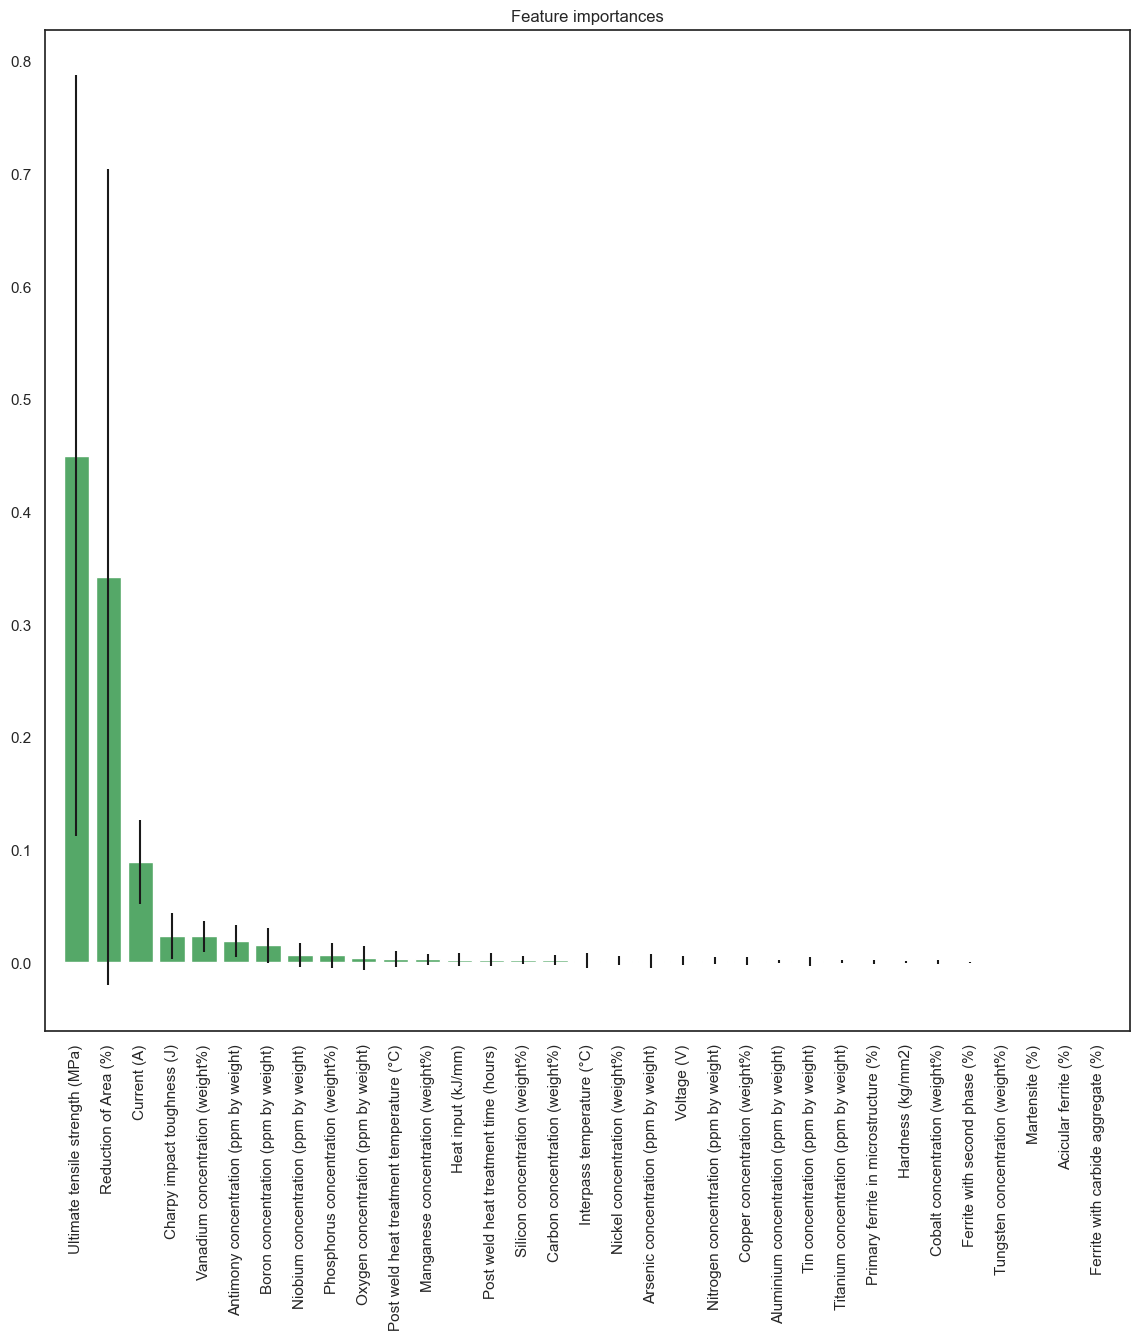

In [62]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Yield strength (MPa)"
features_to_drop = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero')

# Tree based feature selection

regressor_test = RandomForestRegressor().fit(X_train, y_train)
importances = regressor_test.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor_test.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

PCA

,Model,MAPE,R2 Score,MSE
0,Random Forest Regression,1.183096e+16,0.965628,2480.038988
1,Gradient Boosting Regression,3.125417e+16,0.956900,3109.780659
2,Decision Tree Regression,1.756859e+16,0.903950,6930.240889
3,Linear Regression,1.151385e+17,0.784510,15548.160542
4,Ridge Regression,1.180774e+17,0.783966,15587.411346
5,Lasso Regression,1.160262e+17,0.780098,15866.477867
6,ElasticNet Regression,2.448570e+17,0.689342,22414.724997


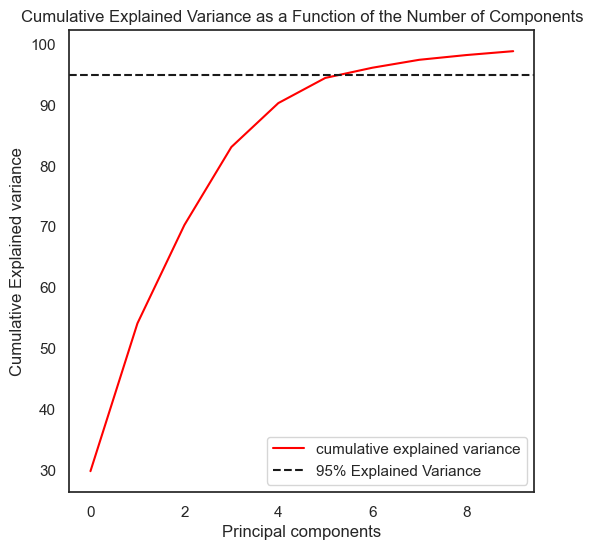

In [63]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Yield strength (MPa)"
features_to_drop = ["Yield strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero',pca=True, pca_n_components=10)

results_df = metrics_pipelines(X_train, X_test, y_train, y_test)
results_df

# Analysis of the Ultimate Tensile Strength

### Modeling - Regression

In [64]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Ultimate tensile strength (MPa)"
features_to_drop = ["Ultimate tensile strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero')

results_df = metrics_pipelines(X_train, X_test, y_train, y_test)
results_df

,Model,MAPE,R2 Score,MSE
0,Gradient Boosting Regression,2.621276e+16,0.980253,1842.589820
1,Random Forest Regression,3.313439e+16,0.970154,2784.886363
2,Decision Tree Regression,1.976125e+16,0.961937,3551.599576
3,Linear Regression,1.752844e+17,0.804053,18283.741920
4,Ridge Regression,1.752337e+17,0.801061,18562.942619
5,Lasso Regression,1.626262e+17,0.785364,20027.598034
6,ElasticNet Regression,2.411211e+17,0.748026,23511.570845


### Feature Selection

Select K-best

In [65]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Ultimate tensile strength (MPa)"
features_to_drop = ["Ultimate tensile strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero', feature_selection_methods=[{'method': 'SelectKBest', 'params': {'k': 10}}])

results_df = metrics_pipelines(X_train, X_test, y_train, y_test)
results_df

,Model,MAPE,R2 Score,MSE
0,Random Forest Regression,4.897076e+16,0.938024,5782.974320
1,Gradient Boosting Regression,6.749120e+16,0.916725,7770.361318
2,Decision Tree Regression,3.624078e+16,0.915215,7911.256162
3,Linear Regression,1.785221e+17,0.783707,20182.256181
4,Ridge Regression,1.784045e+17,0.782671,20278.837875
5,Lasso Regression,1.668918e+17,0.779683,20557.655340
6,ElasticNet Regression,2.472627e+17,0.740161,24245.486368


RFECV

In [66]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Ultimate tensile strength (MPa)"
features_to_drop = ["Ultimate tensile strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero', feature_selection_methods=[{'method': 'RFECV', 'params': {'estimator': RandomForestRegressor(), 'step': 1, 'cv': 5, 'scoring': 'r2'}}])

results_df = metrics_pipelines(X_train, X_test, y_train, y_test)
results_df

,Model,MAPE,R2 Score,MSE
0,Decision Tree Regression,6.332334e+15,0.984188,1475.375717
1,Gradient Boosting Regression,2.799364e+16,0.978890,1969.796732
2,Random Forest Regression,3.102504e+16,0.972016,2611.172579
3,Linear Regression,1.873454e+17,0.789342,19656.448192
4,Ridge Regression,1.853021e+17,0.788881,19699.389360
5,Lasso Regression,1.660899e+17,0.781832,20357.162183
6,ElasticNet Regression,2.438131e+17,0.742706,24008.021604


Tree based feature selection

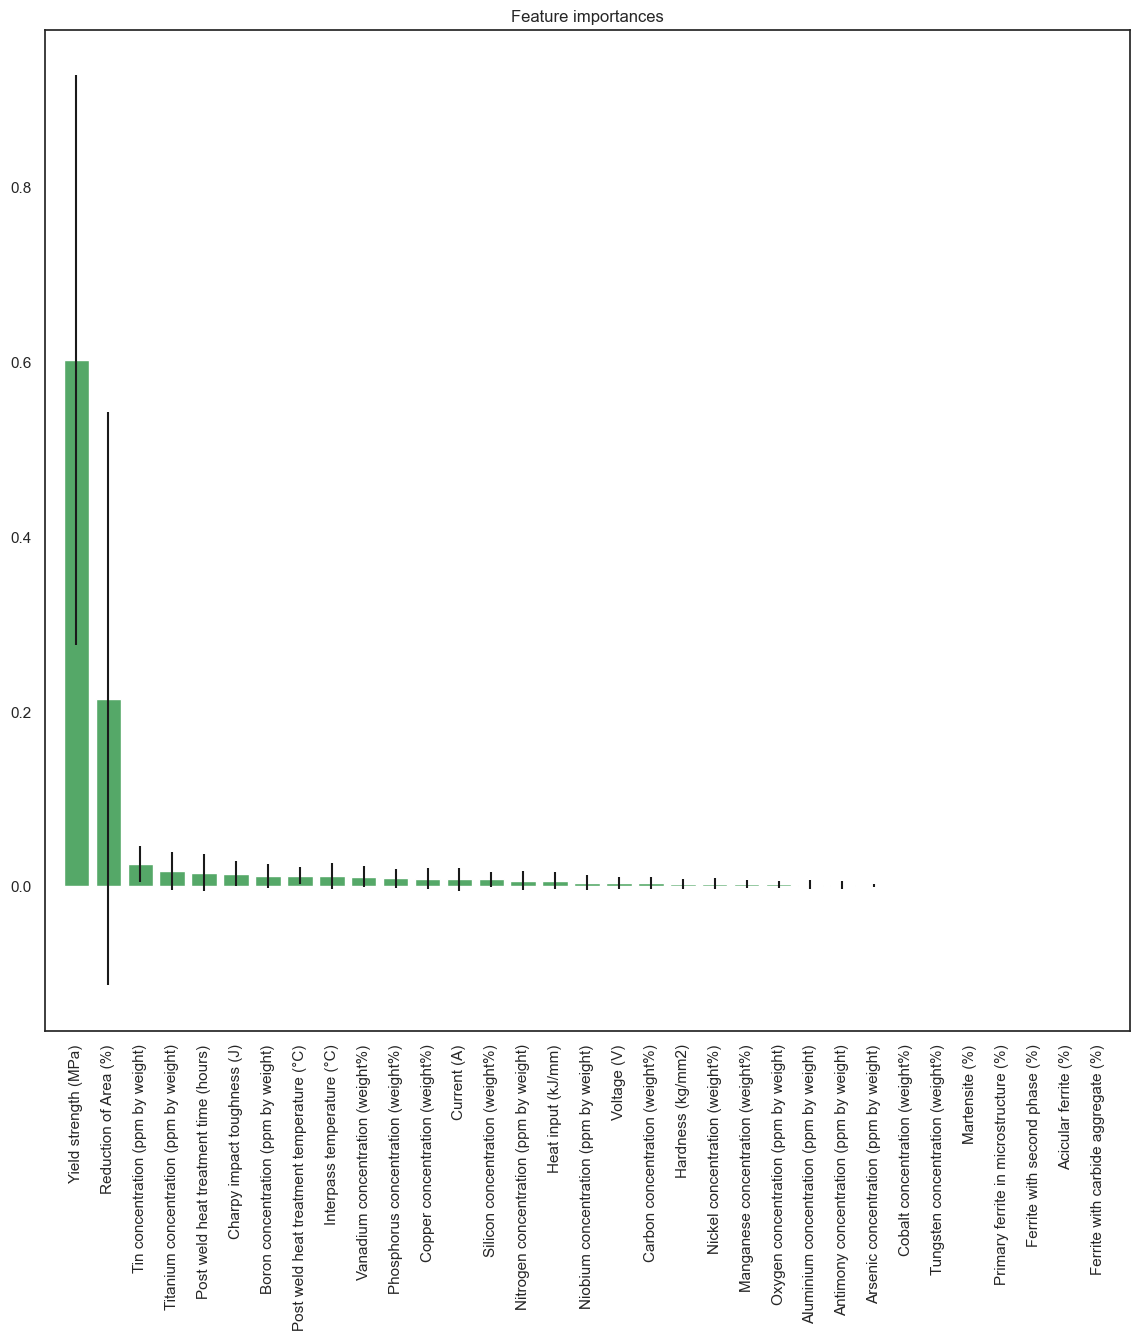

In [67]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Ultimate tensile strength (MPa)"
features_to_drop = ["Ultimate tensile strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero')

# Tree based feature selection

regressor_test = RandomForestRegressor().fit(X_train, y_train)
importances = regressor_test.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor_test.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

PCA

,Model,MAPE,R2 Score,MSE
0,Random Forest Regression,5.616534e+16,0.925198,6979.761741
1,Gradient Boosting Regression,7.264219e+16,0.921809,7295.923607
2,Decision Tree Regression,3.991372e+16,0.814469,17311.844949
3,Ridge Regression,2.036424e+17,0.762482,22162.742210
4,Linear Regression,2.028958e+17,0.761854,22221.291766
5,Lasso Regression,1.987315e+17,0.760207,22375.024947
6,ElasticNet Regression,3.354207e+17,0.686592,29243.929241


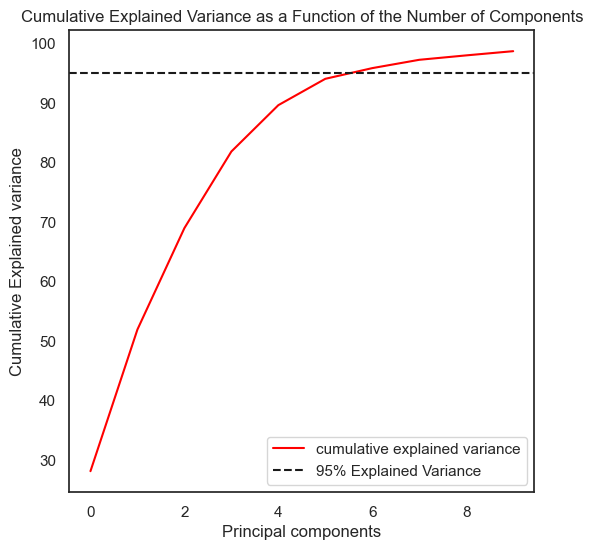

In [68]:
# Define the columns to drop (optional) and the target column
categoric_features = ['Weld ID', 'AC or DC', 'Electrode positive or negative', 'Type of weld']
drop_columns = ['Charpy temperature (°C)', '50% FATT']
target_column = "Ultimate tensile strength (MPa)"
features_to_drop = ["Ultimate tensile strength (MPa)", "Sulphur concentration (weight%)", "Chromium concentration (weight%)", "Molybdenum concentration (weight%)", "Elongation (%)"]

# Preprocess the data
X_train, X_test, y_train, y_test = data_preprocessing(data, target_column, categoric_features,features_to_drop, drop_columns, y_imputation='zero',pca=True, pca_n_components=10)

results_df = metrics_pipelines(X_train, X_test, y_train, y_test)
results_df